In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
%cd /content/gdrive/MyDrive/DL_Project

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/DL_Project'
/content


In [3]:
import numpy as np
# !pip install torch
import torch
import torch.optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import time
import csv
import os
from os import path

batch_size = 64
n_workers = 2

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10820545180340984264, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15703311680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2287024511540641688
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [108]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        imgs = sorted(os.listdir(main_dir))
        self.total_imgs = []
        for i in imgs:
          if 'frame' in i:
            self.total_imgs.append(i) 

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),])

dset = []
loader = []

for i in range(6):
  dset.append(CustomDataSet("scene-change-examples/scene-"+str(i), transform))
  loader.append(DataLoader(dset[i], batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=False, drop_last=False))


In [152]:
def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        x_recon = F.sigmoid(x_recon)
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    print(batch_size)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [153]:
def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

In [154]:
class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x, train=True):
        distributions = self.encoder(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self.decoder(z)

        if not train:
          return x_recon, z
          
        return x_recon, mu, logvar


In [155]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()


In [156]:
model = BetaVAE_H()
print(model)

BetaVAE_H(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): View()
    (11): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): View()
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(64, 32, kernel_siz

In [159]:
def dev(model, dataloader):
  model.eval()
  Z = None
  for i, x in enumerate(dataloader):
    x = x.cuda()
    x_recon, z = model(x, False)
    if Z is None:
      Z = z
    else:
      Z = torch.hstack((Z, z))
  return Z

In [160]:
checkpoint = torch.load('model_0_96')
model_0 = BetaVAE_H()
model_0.load_state_dict(checkpoint['model_state_dict'])
TRL_0 = checkpoint['trl']
TBL_0 = checkpoint['tbl']
TKL_0 = checkpoint['tkl']
RL_0 = checkpoint['rl']
BL_0 = checkpoint['bl']
KL_0 = checkpoint['kl']

checkpoint = torch.load('model_1_99')
model_1 = BetaVAE_H()
model_1.load_state_dict(checkpoint['model_state_dict'])
TRL_1 = checkpoint['trl']
TBL_1 = checkpoint['tbl']
TKL_1 = checkpoint['tkl']
RL_1 = checkpoint['rl']
BL_1 = checkpoint['bl']
KL_1 = checkpoint['kl']

checkpoint = torch.load('model_2_99')
model_2 = BetaVAE_H()
model_2.load_state_dict(checkpoint['model_state_dict'])
TRL_2 = checkpoint['trl']
TBL_2 = checkpoint['tbl']
TKL_2 = checkpoint['tkl']
RL_2 = checkpoint['rl']
BL_2 = checkpoint['bl']
KL_2 = checkpoint['kl']


Text(0, 0.5, 'Loss')

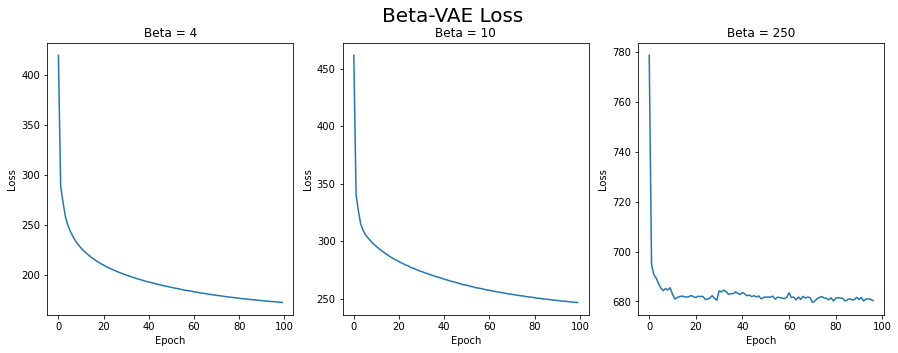

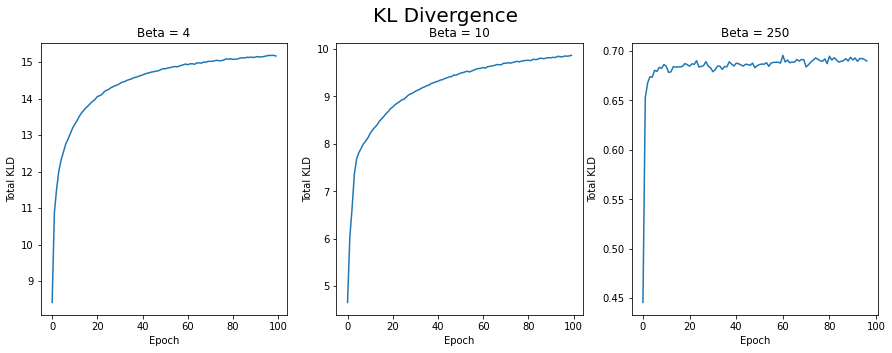

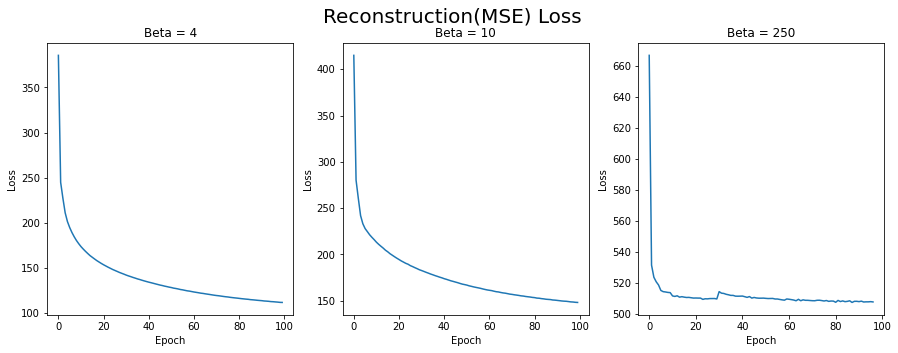

In [161]:
import matplotlib.pyplot as plt

fig1, axs1 = plt.subplots(1, 3, figsize=(15,5))
fig2, axs2 = plt.subplots(1, 3, figsize=(15,5))
fig3, axs3 = plt.subplots(1, 3, figsize=(15,5))
fig1.suptitle('Beta-VAE Loss', fontsize=20)
fig2.suptitle('KL Divergence', fontsize=20)
fig3.suptitle('Reconstruction(MSE) Loss', fontsize=20)


axs1[0].plot(BL_1)
axs1[0].set_title('Beta = 4')
axs1[0].set_xlabel('Epoch', fontsize=10)
axs1[0].set_ylabel('Loss', fontsize=10)
axs1[1].plot(BL_2)
axs1[1].set_title('Beta = 10')
axs1[1].set_xlabel('Epoch', fontsize=10)
axs1[1].set_ylabel('Loss', fontsize=10)
axs1[2].plot(BL_0)
axs1[2].set_title('Beta = 250')
axs1[2].set_xlabel('Epoch', fontsize=10)
axs1[2].set_ylabel('Loss', fontsize=10)

axs2[0].plot(KL_1)
axs2[0].set_title('Beta = 4')
axs2[0].set_xlabel('Epoch', fontsize=10)
axs2[0].set_ylabel('Total KLD', fontsize=10)
axs2[1].plot(KL_2)
axs2[1].set_title('Beta = 10')
axs2[1].set_xlabel('Epoch', fontsize=10)
axs2[1].set_ylabel('Total KLD', fontsize=10)
axs2[2].plot(KL_0)
axs2[2].set_title('Beta = 250')
axs2[2].set_xlabel('Epoch', fontsize=10)
axs2[2].set_ylabel('Total KLD', fontsize=10)

axs3[0].plot(RL_1)
axs3[0].set_title('Beta = 4')
axs3[0].set_xlabel('Epoch', fontsize=10)
axs3[0].set_ylabel('Loss', fontsize=10)
axs3[1].plot(RL_2)
axs3[1].set_title('Beta = 10')
axs3[1].set_xlabel('Epoch', fontsize=10)
axs3[1].set_ylabel('Loss', fontsize=10)
axs3[2].plot(RL_0)
axs3[2].set_title('Beta = 250')
axs3[2].set_xlabel('Epoch', fontsize=10)
axs3[2].set_ylabel('Loss', fontsize=10)


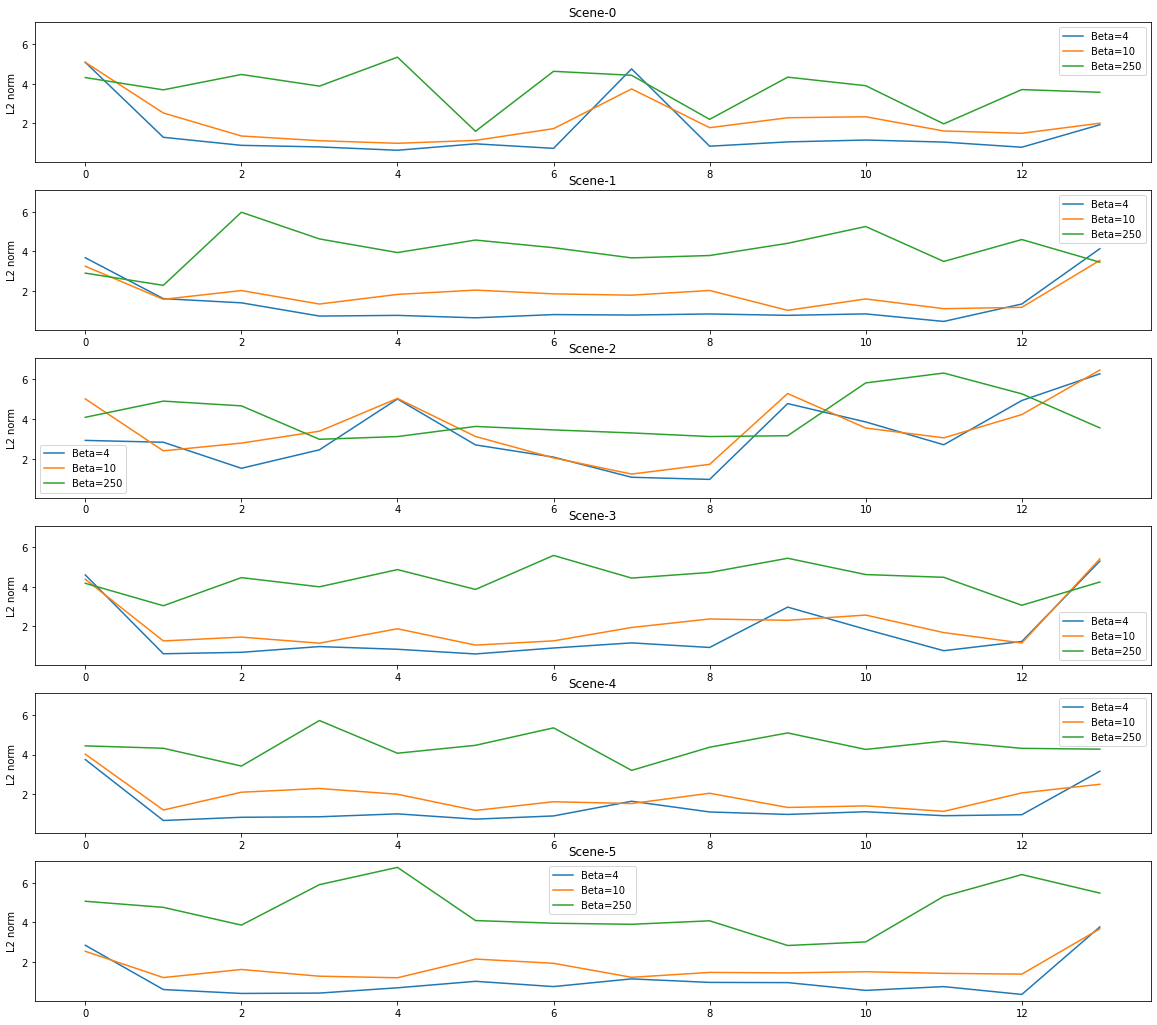

In [163]:
fig, axs = plt.subplots(6, figsize=(20,18), sharey=True)
for j in range(6):
  loader_temp = loader[j]

  model_0.cuda()
  Z_0 = dev(model_0, loader_temp).cpu().detach()
  metric_0 = []
  for i in range(Z_0.shape[0] - 1):
    metric = torch.norm(Z_0[i]-Z_0[i+1], 2)
    metric_0.append(metric.item())

  model_1.cuda()
  Z_1 = dev(model_1, loader_temp).cpu().detach()
  metric_1 = []
  for i in range(Z_1.shape[0] - 1):
    metric = torch.norm(Z_1[i]-Z_1[i+1], 2)
    metric_1.append(metric.item())

  model_2.cuda()
  Z_2 = dev(model_2, loader_temp).cpu().detach()
  metric_2 = []
  for i in range(Z_2.shape[0] - 1):
    metric = torch.norm(Z_2[i]-Z_2[i+1], 2)
    metric_2.append(metric.item())

  axs[j].set_title("Scene-"+str(j))
  # axs[j].set_xlabel("Frame Transition")
  axs[j].set_ylabel("L2 norm")
  axs[j].plot(metric_1) 
  axs[j].plot(metric_2) 
  axs[j].plot(metric_0) 
  axs[j].legend(['Beta=4', 'Beta=10', 'Beta=250'])
